# Regression using tree based algorithm

Estimate (i.e. make regression for) the energy of electrons. This should be based on maximum 15 variables from the Electron Variable List. The target variable for this task is "p_truth_E": Energy (in GeV) of the electrons, and you should only train on real (i.e. truth identified, "Truth==1") electrons. Note: It is an advantage to ONLY train the regression on true electrons (Truth = 1), but when submitting the solution, the regression estimate should be applied to ALL candidates, as you don't (perfectly) know, which are electrons, and which are not. We evaluate algorithm performance by considering Mean Absolute Error (MAE) on relative estimate accuracy: (E_pred-E_true)/E_true.

We start by opening the files and loading them into a Numpy array

In [1]:
import h5py
import pandas
from copy import deepcopy
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [2]:
def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        return pandas.DataFrame(f[name][:])

train = load_data('train')
test  = load_data('test')

In [3]:
## temporarily use a fraction of the data to speed everything up
train=train.sample(frac = 0.3)

Then we can verify the shape

In [4]:
print (f'Shape of training data set: {train.shape}')
print (f'Shape of test data set: {test.shape}')

Shape of training data set: (48750, 166)
Shape of test data set: (160651, 164)


As expected, the test set contains 2 columns less: `Truth` and `p_truth_E`.
    
Then we copy the variable list from the course website <https://www.nbi.dk/~petersen/Teaching/ML2020/SmallProject/VariableList.html>

In [5]:
all_variables = ['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'correctedActualMu', 'correctedAverageMu', 'correctedScaledActualMu', 'correctedScaledAverageMu', 'NvtxReco', 'p_nTracks', 'p_pt_track', 'p_eta', 'p_phi', 'p_charge', 'p_qOverP', 'p_z0', 'p_d0', 'p_sigmad0', 'p_d0Sig', 'p_EptRatio', 'p_dPOverP', 'p_z0theta', 'p_etaCluster', 'p_phiCluster', 'p_eCluster', 'p_rawEtaCluster', 'p_rawPhiCluster', 'p_rawECluster', 'p_eClusterLr0', 'p_eClusterLr1', 'p_eClusterLr2', 'p_eClusterLr3', 'p_etaClusterLr1', 'p_etaClusterLr2', 'p_phiClusterLr2', 'p_eAccCluster', 'p_f0Cluster', 'p_etaCalo', 'p_phiCalo', 'p_eTileGap3Cluster', 'p_cellIndexCluster', 'p_phiModCalo', 'p_etaModCalo', 'p_dPhiTH3', 'p_R12', 'p_fTG3', 'p_weta2', 'p_Reta', 'p_Rphi', 'p_Eratio', 'p_f1', 'p_f3', 'p_Rhad', 'p_Rhad1', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_TRTPID', 'p_TRTTrackOccupancy', 'p_numberOfInnermostPixelHits', 'p_numberOfPixelHits', 'p_numberOfSCTHits', 'p_numberOfTRTHits', 'p_numberOfTRTXenonHits', 'p_chi2', 'p_ndof', 'p_SharedMuonTrack', 'p_E7x7_Lr2', 'p_E7x7_Lr3', 'p_E_Lr0_HiG', 'p_E_Lr0_LowG', 'p_E_Lr0_MedG', 'p_E_Lr1_HiG', 'p_E_Lr1_LowG', 'p_E_Lr1_MedG', 'p_E_Lr2_HiG', 'p_E_Lr2_LowG', 'p_E_Lr2_MedG', 'p_E_Lr3_HiG', 'p_E_Lr3_LowG', 'p_E_Lr3_MedG', 'p_ambiguityType', 'p_asy1', 'p_author', 'p_barys1', 'p_core57cellsEnergyCorrection', 'p_deltaEta0', 'p_deltaEta2', 'p_deltaEta3', 'p_deltaPhi0', 'p_deltaPhi1', 'p_deltaPhi2', 'p_deltaPhi3', 'p_deltaPhiFromLastMeasurement', 'p_deltaPhiRescaled0', 'p_deltaPhiRescaled1', 'p_deltaPhiRescaled3', 'p_e1152', 'p_e132', 'p_e235', 'p_e255', 'p_e2ts1', 'p_ecore', 'p_emins1', 'p_etconeCorrBitset', 'p_ethad', 'p_ethad1', 'p_f1core', 'p_f3core', 'p_maxEcell_energy', 'p_maxEcell_gain', 'p_maxEcell_time', 'p_maxEcell_x', 'p_maxEcell_y', 'p_maxEcell_z', 'p_nCells_Lr0_HiG', 'p_nCells_Lr0_LowG', 'p_nCells_Lr0_MedG', 'p_nCells_Lr1_HiG', 'p_nCells_Lr1_LowG', 'p_nCells_Lr1_MedG', 'p_nCells_Lr2_HiG', 'p_nCells_Lr2_LowG', 'p_nCells_Lr2_MedG', 'p_nCells_Lr3_HiG', 'p_nCells_Lr3_LowG', 'p_nCells_Lr3_MedG', 'p_pos', 'p_pos7', 'p_poscs1', 'p_poscs2', 'p_ptconeCorrBitset', 'p_ptconecoreTrackPtrCorrection', 'p_r33over37allcalo', 'p_topoetconeCorrBitset', 'p_topoetconecoreConeEnergyCorrection', 'p_topoetconecoreConeSCEnergyCorrection', 'p_weta1', 'p_widths1', 'p_widths2', 'p_wtots1', 'p_e233', 'p_e237', 'p_e277', 'p_e2tsts1', 'p_ehad1', 'p_emaxs1', 'p_fracs1', 'p_DeltaE', 'p_E3x5_Lr0', 'p_E3x5_Lr1', 'p_E3x5_Lr2', 'p_E3x5_Lr3', 'p_E5x7_Lr0', 'p_E5x7_Lr1', 'p_E5x7_Lr2', 'p_E5x7_Lr3', 'p_E7x11_Lr0', 'p_E7x11_Lr1', 'p_E7x11_Lr2', 'p_E7x11_Lr3', 'p_E7x7_Lr0', 'p_E7x7_Lr1' ]

Finally, we divide the training data into data (`X`) and targets (`y`)

Only use the entries which we know are true electrons for training.


In [6]:
train = train.loc[train['Truth']==1]
X = train[all_variables]
y = train['p_truth_E']

print (f'Shape of X: {X.shape}')
print (f'Shape of y: {y.shape}')

Shape of X: (36362, 160)
Shape of y: (36362,)


In [7]:
X.head(2)

,actualInteractionsPerCrossing,averageInteractionsPerCrossing,correctedActualMu,correctedAverageMu,correctedScaledActualMu,correctedScaledAverageMu,NvtxReco,p_nTracks,p_pt_track,p_eta,...,p_E5x7_Lr0,p_E5x7_Lr1,p_E5x7_Lr2,p_E5x7_Lr3,p_E7x11_Lr0,p_E7x11_Lr1,p_E7x11_Lr2,p_E7x11_Lr3,p_E7x7_Lr0,p_E7x7_Lr1
137724,21.5,21.5,21.5,21.5,21.5,21.5,11,2,12536.642578,-2.334869,...,0.0,37882.343750,108024.742188,419.364288,0.0,38573.976562,115936.875000,1431.651855,0.0,38573.976562
115679,45.5,45.5,45.5,45.5,45.5,45.5,27,1,34243.476562,-2.057073,...,0.0,25346.253906,152359.109375,638.356689,0.0,24643.673828,153900.578125,400.548279,0.0,24643.673828


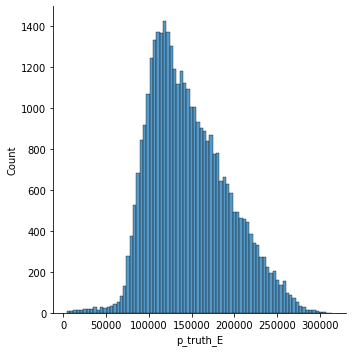

In [9]:
sns.displot(data=train, x=y)

## Preprocessing

### Check null values

In [10]:
train.isnull().sum()

eventNumber                       0
runNumber                         0
actualInteractionsPerCrossing     0
averageInteractionsPerCrossing    0
correctedActualMu                 0
                                 ..
p_E7x11_Lr2                       0
p_E7x11_Lr3                       0
p_E7x7_Lr0                        0
p_E7x7_Lr1                        0
index                             0
Length: 166, dtype: int64

No nulls
### Scale the data

In [11]:
transformed_X = deepcopy(X) 
# This loop transforms every variable _independently_ 
for variable in X.columns:     
    transformed_X[variable] = RobustScaler().fit_transform(np.array(transformed_X[variable]).reshape(-1,1))

### Select k Best features

In [12]:
from sklearn.feature_selection import SelectKBest, f_regression

In [13]:
X_15 = SelectKBest(score_func=f_regression, k=15).fit_transform(X, y)
X_15.shape

/opt/conda/envs/python3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/opt/conda/envs/python3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/conda/envs/python3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/opt/conda/envs/python3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/envs/python3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/conda/envs/python3/lib/python3.7/site-packages/scipy/stats/_dis

(36362, 15)

## XGBoost regression

In [17]:
# xgboost for regression
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
# evaluate the model
model = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_15, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
# fit the model on the whole dataset
model = XGBRegressor(objective='reg:squarederror')
model.fit(X, y)


MAE: -7002.942 (184.652)


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

## LightGBM regression

In [19]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# evaluate the model
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_15, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
# fit the model on the whole dataset
model = LGBMRegressor()
model.fit(X, y)


MAE: -6743.779 (186.857)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Hyperparameter tuning

### Random Search

In [21]:
from scipy.stats import loguniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

# define model
model = Ridge()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = loguniform(1e-5, 100)
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_15, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -6500.0870659898965
Best Hyperparameters: {'alpha': 0.0002531181460133387, 'fit_intercept': True, 'normalize': True, 'solver': 'svd'}


### Grid Search

In [23]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

# define model
model = Ridge()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
# define search
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, verbose=1)
# execute search
result = search.fit(X_15, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 30 folds for each of 128 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 487 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 837 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1287 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1837 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2487 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3237 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  6.3min finished


Best Score: -6502.898942656773
Best Hyperparameters: {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}
